# Introduction

**Chronic kidney disease** (CKD) refers to the slow and progressive loss of kidney function over a period of several years, which may eventually result in permanent kidney failure. As the disease worsens and the kidney's function is further impaired, dangerous levels of fluid and water can accumulate in the body, amongst other complications.

There are 5 stages of CKD and most patients have stage 3 CKD.

Diabetes and high blood pressure are the leading causes of CKD and are responsible for about two-thirds of the cases.

# Problem Statement

Using a set of longitudinal data of different lab measurements for patients diagnosed with chronic kidney disease (CKD), to build a classification model to predict whether a patient will progress in CKD staging given his/her past longitudinal information.

We would want to optimize for both ROC-AUC and recall - as the main aim should be to positively identify patients who are likely to progress to the next stage of CKD given their current health records, which allows for more targeted intervention. 

# Libraries and Imports

In [177]:
# import relevant libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# import models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# import ensemble for voting classification
from sklearn.ensemble import VotingClassifier

# importing metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, recall_score

# Import Data

In [178]:
file_names = [
    'T_creatinine.csv', 
    'T_DBP.csv',
    'T_demo.csv',
    'T_glucose.csv',
    'T_HGB.csv',
    'T_ldl.csv',
    'T_meds.csv',
    'T_SBP.csv',
    'T_stage.csv'
]

dfs = [pd.read_csv(f'../data/{df}') for df in file_names]

In [179]:
creatinine = dfs[0]
dbp = dfs[1]
demo = dfs[2]
glucose = dfs[3]
hgb = dfs[4]
ldl = dfs[5]
meds = dfs[6]
sbp = dfs[7]
stage = dfs[8]

# Preliminary Data Exploration

In [180]:
# create dictionary of dataframes and names

loaded_dfs = {
    "Creatinine": creatinine,
    "Diastolic Blood Pressure": dbp,
    "Demographics": demo,
    "Glucose": glucose,
    "Haemoglobin": hgb,
    "Low-Density Lipoprotein": ldl,
    "Medications": meds,
    "Systolic Blood Pressure": sbp,
    "Stage": stage
}

In [181]:
# print dataframe header

for df_name, df in loaded_dfs.items():
    print('-------')
    print(f'{df_name}')
    print('-------')
    print(df.head())
    print(' ')

-------
Creatinine
-------
   id  value  time
0   0   1.29     0
1   0   1.15   107
2   0   1.44   286
3   0   1.23   382
4   0   1.08   580
 
-------
Diastolic Blood Pressure
-------
   id  value  time
0   0  95.32     0
1   0  83.98    98
2   0  65.97   279
3   0  83.41   380
4   0  86.39   475
 
-------
Demographics
-------
   id     race  gender  age
0   0  Unknown    Male   70
1   1    White  Female   71
2   2    White  Female   57
3   3    White    Male   74
4   4    White  Female   50
 
-------
Glucose
-------
   id  value  time
0   0   6.24     0
1   0   7.20   107
2   0   7.01   286
3   0   6.89   382
4   0   5.62   580
 
-------
Haemoglobin
-------
   id  value  time
0   0  13.51     0
1   0  13.39   107
2   0  12.84   286
3   0  13.32   382
4   0  13.53   688
 
-------
Low-Density Lipoprotein
-------
   id   value  time
0   0  161.49     0
1   0  111.39   107
2   0  157.90   382
3   1   89.57     0
4   1   98.73   221
 
-------
Medications
-------
   id          drug  daily_

In [182]:
# print dataframe information

for df_name, df in loaded_dfs.items():
    print('-------')
    print(f'{df_name}')
    print('-------')
    print(df.info())
    print(' ')

-------
Creatinine
-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1439 non-null   int64  
 1   value   1439 non-null   float64
 2   time    1439 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 33.9 KB
None
 
-------
Diastolic Blood Pressure
-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1821 non-null   int64  
 1   value   1821 non-null   float64
 2   time    1821 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 42.8 KB
None
 
-------
Demographics
-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      300 non-null    

**Observations**

There are 300 IDs (patients) in total.

No missing values observed in the dataset in the form of null values.

However, each of the datasets has a different number of rows - indicative that each patient may have had a different number of measurements taken for each health parameter, and at different times.

Our binary target variable is contained in the `stage` dataframe.

In [183]:
# check for value count of target variable

stage['Stage_Progress'].value_counts()

False    200
True     100
Name: Stage_Progress, dtype: int64

In [184]:
# check for value count of target variable (normalized)

stage['Stage_Progress'].value_counts(normalize=True)

False    0.666667
True     0.333333
Name: Stage_Progress, dtype: float64

In [185]:
# print dataframe data types

for df_name, df in loaded_dfs.items():
    print('-------')
    print(f'{df_name}')
    print('-------')
    print(df.dtypes)
    print(' ')

-------
Creatinine
-------
id         int64
value    float64
time       int64
dtype: object
 
-------
Diastolic Blood Pressure
-------
id         int64
value    float64
time       int64
dtype: object
 
-------
Demographics
-------
id         int64
race      object
gender    object
age        int64
dtype: object
 
-------
Glucose
-------
id         int64
value    float64
time       int64
dtype: object
 
-------
Haemoglobin
-------
id         int64
value    float64
time       int64
dtype: object
 
-------
Low-Density Lipoprotein
-------
id         int64
value    float64
time       int64
dtype: object
 
-------
Medications
-------
id                int64
drug             object
daily_dosage    float64
start_day         int64
end_day           int64
dtype: object
 
-------
Systolic Blood Pressure
-------
id         int64
value    float64
time       int64
dtype: object
 
-------
Stage
-------
id                int64
Stage_Progress     bool
dtype: object
 


All fields look to be of the correct type.

# Preliminary Data Cleaning

In [186]:
# encode stage into 1/0

stage['Stage_Progress'] = stage['Stage_Progress'].map({False: 0, True: 1})

In [187]:
stage.rename(columns={'Stage_Progress': 'stage'}, inplace=True)

In [188]:
# merge the 6 purely numeric dataframes first

for df_name, df in loaded_dfs.items():
    if df_name not in ('Medications', 'Stage'):
        loaded_dfs[df_name] = pd.merge(df, stage)

# Exploratory Data Analysis

For the dataframes which include only a single numeric column, we can plot the trends using a line plot to visualize the change in measurement over time.

This also aids in the feature selection process, where the features which are deemed to have a significant effect on our target variable will be kept. 

In [189]:
def plot_subplots(df, df_name, x_col, y_col, target_var, hue):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
    ax = ax.ravel()
    
    sns.lineplot(data=df[df[target_var]==0], x=x_col, y=y_col, hue=hue, ax=ax[0])
    ax[0].set_title(f'Lineplot for {df_name}, {target_var} = 0')
    sns.lineplot(data=df[df[target_var]==1], x=x_col, y=y_col, hue=hue, ax=ax[1])
    ax[1].set_title(f'Lineplot for {df_name}, {target_var} = 1')

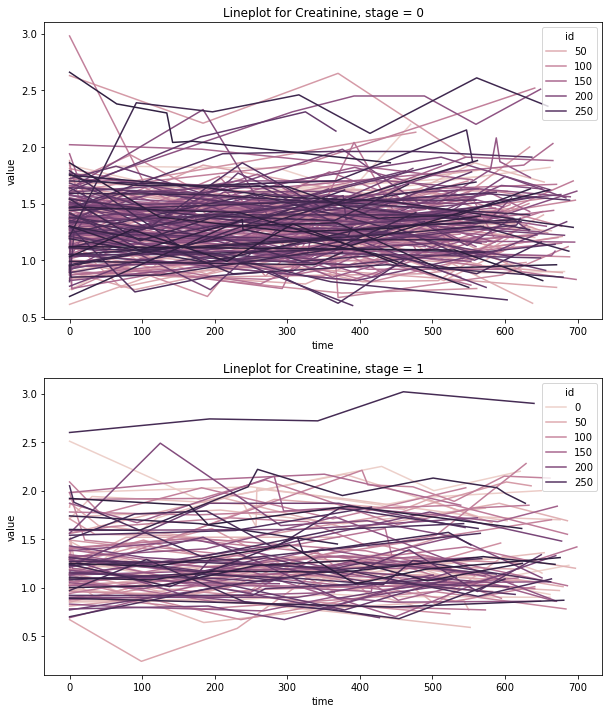

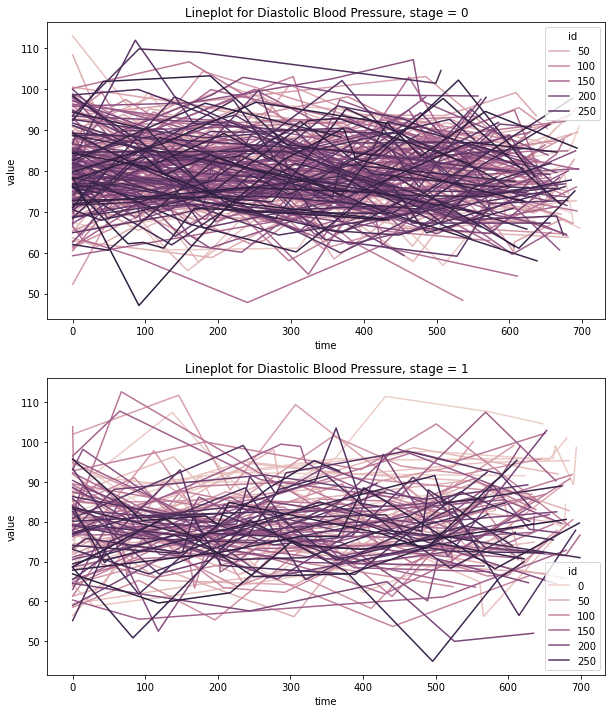

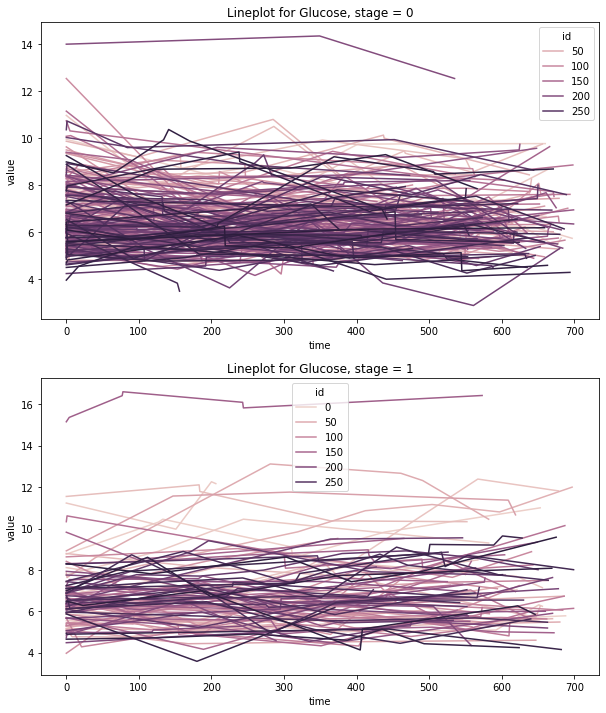

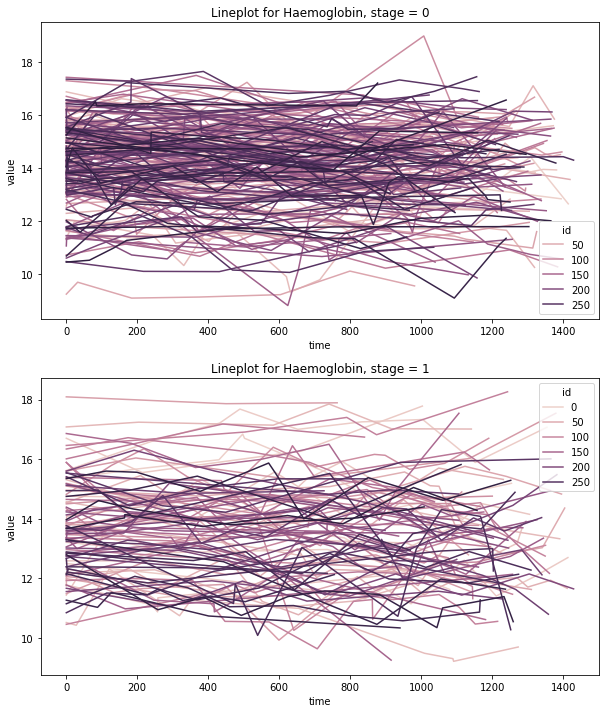

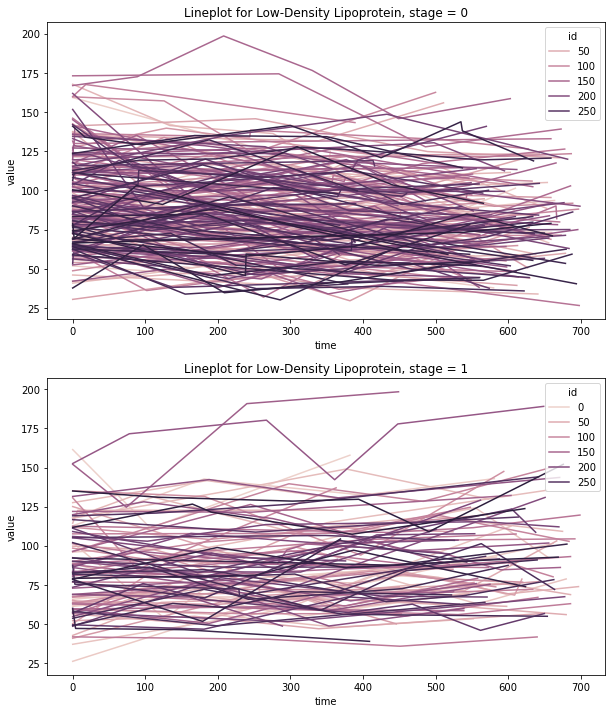

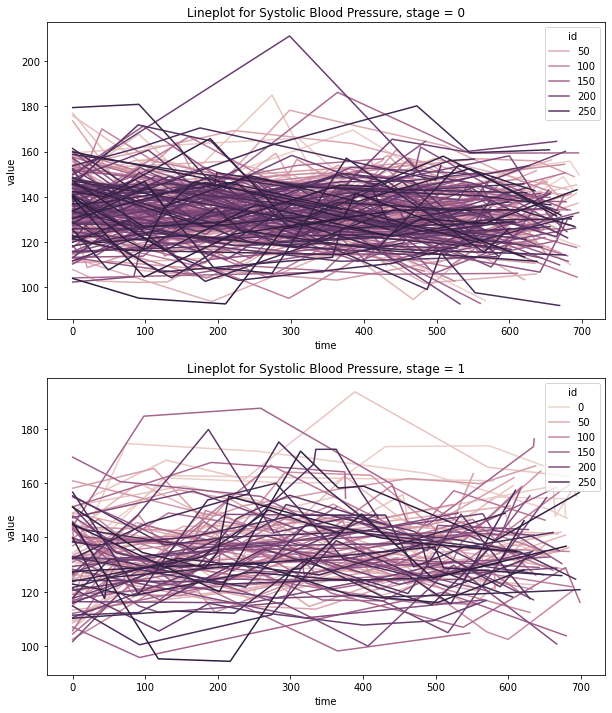

In [190]:
for df_name, df in loaded_dfs.items():
    if df_name not in ('Medications', 'Stage', 'Demographics'):
        plot_subplots(df, df_name, 'time', 'value', 'stage', 'id')

**Observations**

For Glucose, there are a few outlier readings which are significantly higher than the rest.

**Normal levels for glucose and blood pressure**

- Glucose: between 72 - 99 mg/DL when fasting, up to 140 mg/DL 2 hours after eating
- Systolic blood pressure: < 120 mmHg
- Diastolic blood pressure: < 80 mmHg

# Feature Engineering

It is difficult to conduct a time series analysis given that the measurements in time are all varied and the number of data points for each patient also differs. As such, we will attempt to condense each parameter into a single value and transform the longitudinal data into a wide-form instead.

This assumes that the data is stationary.

## Numeric Parameters

In [191]:
overall_df = pd.DataFrame()

for df_name, df in loaded_dfs.items():
    if df_name not in ('Medications', 'Stage', 'Demographics'):
        overall_df[f'{df_name}_mean'] = loaded_dfs[df_name].groupby('id')['value'].mean()
        overall_df[f'{df_name}_std'] = loaded_dfs[df_name].groupby('id')['value'].std()

In [192]:
overall_df.columns = overall_df.columns.str.lower()

## Drugs

In [193]:
meds

,id,drug,daily_dosage,start_day,end_day
0,0,atorvastatin,10.0,19,109
1,0,atorvastatin,10.0,117,207
2,0,losartan,100.0,19,289
3,0,losartan,100.0,403,493
4,0,losartan,100.0,587,677
...,...,...,...,...,...
2176,299,losartan,100.0,144,174
2177,299,losartan,100.0,461,491
2178,299,losartan,100.0,497,527
2179,299,losartan,100.0,529,559


In [194]:
meds_df = meds.groupby(['id', 'drug']).agg({'start_day': ['sum'], 
                                            'end_day': ['sum'], 
                                            'daily_dosage': ['mean']})

In [195]:
meds_df.head()

start_day end_day daily_dosage
                      sum     sum         mean
id drug                                       
0  atorvastatin       136     316         10.0
   losartan          1009    1459        100.0
   metformin         1789    2449       1000.0
1  atorvastatin       828    1128         30.0
2  rosuvastatin       790     970         10.0

In [196]:
meds_df.reset_index(inplace=True)

In [197]:
meds_df.columns = ['id', 'drug', 'start_day', 'end_day', 'daily_dosage']

In [198]:
meds_df['total_days'] = meds_df['end_day'] - meds_df['start_day']

In [199]:
meds_df['total_dosage'] = meds_df['total_days'] * meds_df['daily_dosage']

In [200]:
meds_df.drop(columns=['start_day', 'end_day', 'daily_dosage', 'total_days'], axis=1)

,id,drug,total_dosage
0,0,atorvastatin,1800.0
1,0,losartan,45000.0
2,0,metformin,660000.0
3,1,atorvastatin,9000.0
4,2,rosuvastatin,1800.0
...,...,...,...
606,297,valsartan,170880.0
607,298,atorvastatin,3600.0
608,298,metformin,180000.0
609,299,atorvastatin,1200.0


In [201]:
meds_df = meds_df.reset_index().pivot(index='id', columns=['drug'], values=['total_dosage'])

In [202]:
meds_df.fillna(0, inplace=True)

In [203]:
meds_df.columns = meds_df.columns.droplevel(0)

In [204]:
overall_df = pd.merge(overall_df, meds_df, right_index=True, left_on='id')

In [205]:
overall_df = pd.merge(overall_df, stage, right_index=True, left_index=True)

In [206]:
overall_df.head()

,creatinine_mean,creatinine_std,diastolic blood pressure_mean,diastolic blood pressure_std,glucose_mean,glucose_std,haemoglobin_mean,haemoglobin_std,low-density lipoprotein_mean,low-density lipoprotein_std,...,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan,id,stage
0,1.236667,0.123558,83.173750,8.439941,6.456667,0.671019,13.262222,0.336926,143.593333,27.946610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,1.838000,0.219932,80.455714,6.509255,9.240000,0.818138,13.662857,0.740084,82.424000,11.520748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,2.170000,0.239896,89.217500,5.402693,6.466667,1.170527,15.700000,0.820662,75.283333,12.855568,...,0.0,0.0,0.0,0.0,1800.0,0.0,0.0,0.0,2,1
3,0.996000,0.235648,74.857143,6.390231,6.525000,0.838469,13.198000,0.818655,98.246000,10.749676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
4,1.150000,0.166253,97.385714,10.760423,9.720000,0.924193,12.658000,0.613612,65.907500,8.037397,...,0.0,0.0,28800.0,0.0,0.0,0.0,0.0,0.0,4,1


## Demographics

In [207]:
overall_df = pd.merge(overall_df, demo, right_on='id', left_on='id').drop('id', axis=1)

In [208]:
overall_df = pd.get_dummies(overall_df, columns=['race', 'gender'], drop_first=True)

In [209]:
overall_df.head()

,creatinine_mean,creatinine_std,diastolic blood pressure_mean,diastolic blood pressure_std,glucose_mean,glucose_std,haemoglobin_mean,haemoglobin_std,low-density lipoprotein_mean,low-density lipoprotein_std,...,simvastatin,telmisartan,valsartan,stage,age,race_Black,race_Hispanic,race_Unknown,race_White,gender_Male
0,1.236667,0.123558,83.173750,8.439941,6.456667,0.671019,13.262222,0.336926,143.593333,27.946610,...,0.0,0.0,0.0,1,70,0,0,1,0,1
1,1.838000,0.219932,80.455714,6.509255,9.240000,0.818138,13.662857,0.740084,82.424000,11.520748,...,0.0,0.0,0.0,0,71,0,0,0,1,0
2,2.170000,0.239896,89.217500,5.402693,6.466667,1.170527,15.700000,0.820662,75.283333,12.855568,...,0.0,0.0,0.0,1,57,0,0,0,1,0
3,0.996000,0.235648,74.857143,6.390231,6.525000,0.838469,13.198000,0.818655,98.246000,10.749676,...,0.0,0.0,0.0,0,74,0,0,0,1,1
4,1.150000,0.166253,97.385714,10.760423,9.720000,0.924193,12.658000,0.613612,65.907500,8.037397,...,0.0,0.0,0.0,1,50,0,0,0,1,0


# Feature Selection

In [210]:
# define feature set

features = ['creatinine_mean', 'creatinine_std', 'diastolic blood pressure_mean',
       'diastolic blood pressure_std', 'glucose_mean', 'glucose_std',
       'haemoglobin_mean', 'haemoglobin_std', 'low-density lipoprotein_mean',
       'low-density lipoprotein_std', 'systolic blood pressure_mean',
       'systolic blood pressure_std', 'age']

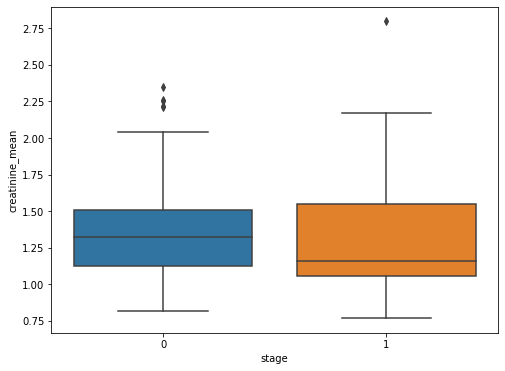

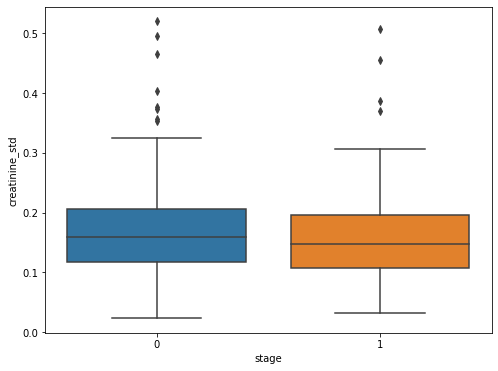

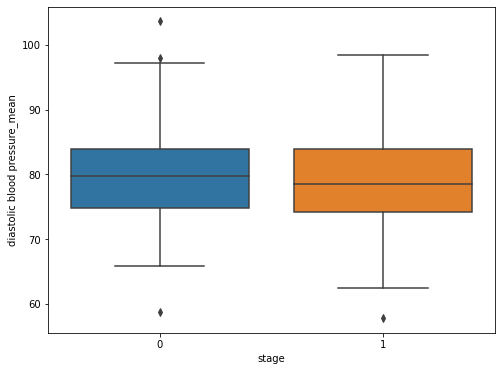

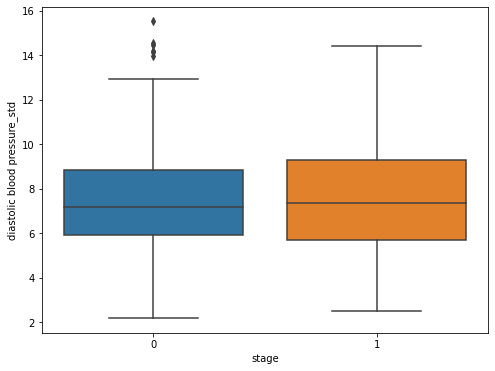

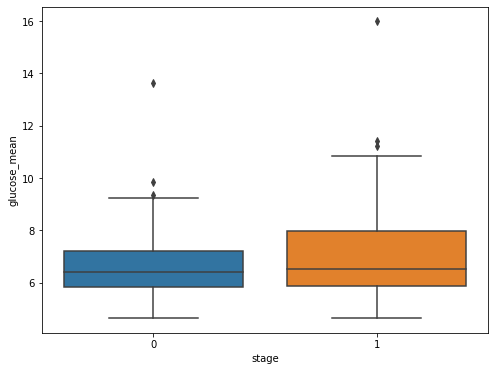

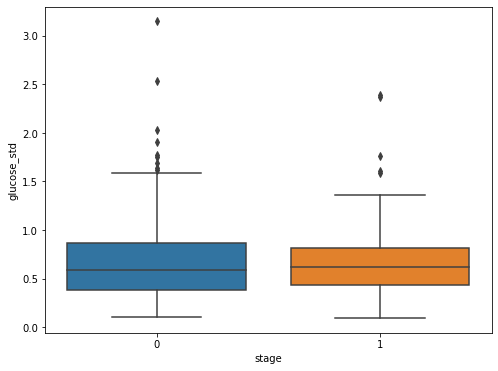

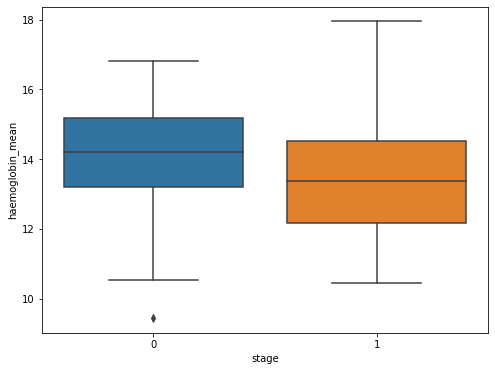

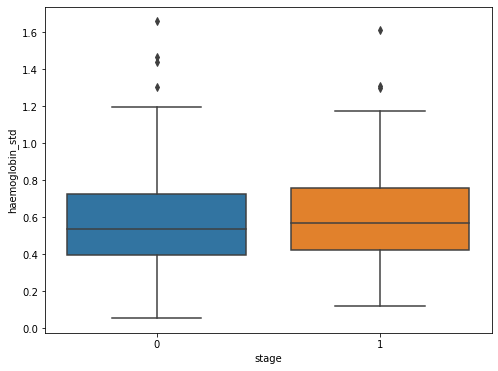

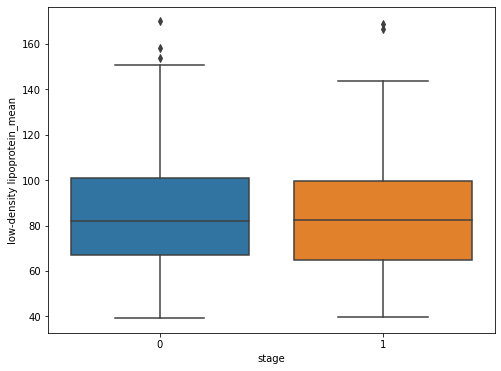

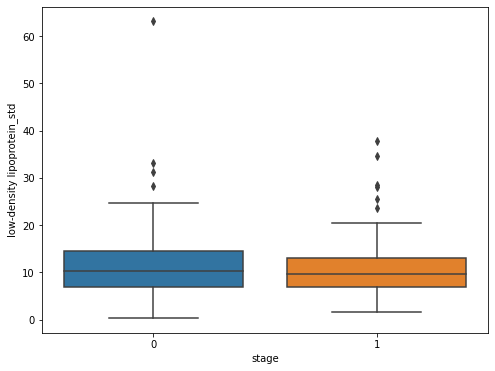

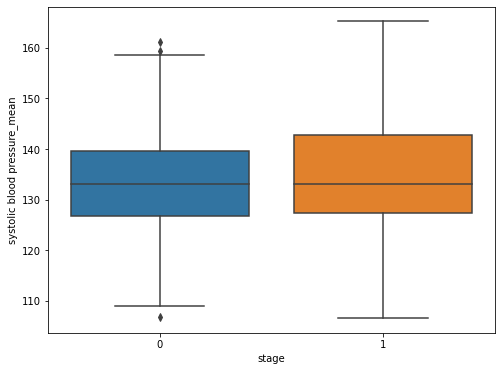

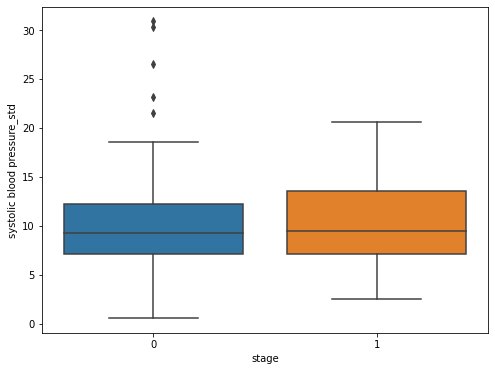

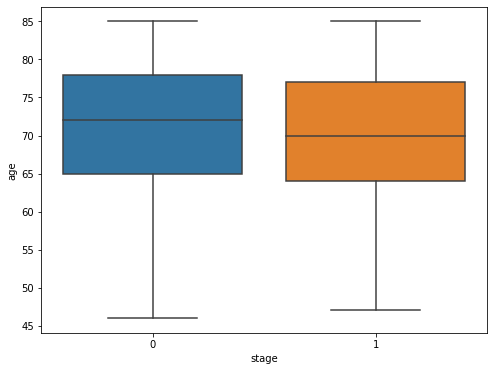

In [211]:
# boxplots of the numeric variables, segregated by stage

for num_feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=overall_df, x='stage', y=num_feature);

<ipython-input-212-c5c770ad7e16>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 6))


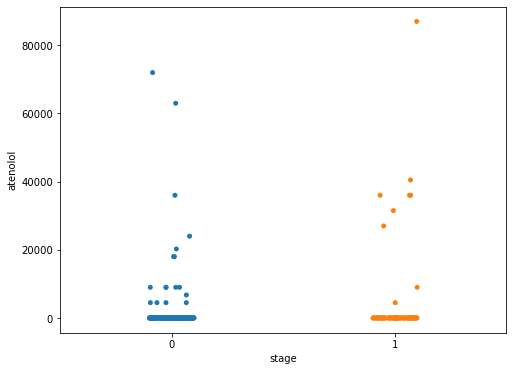

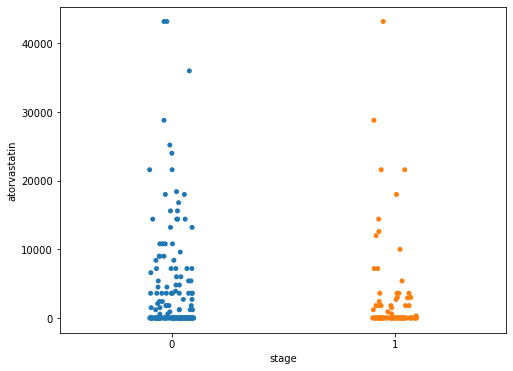

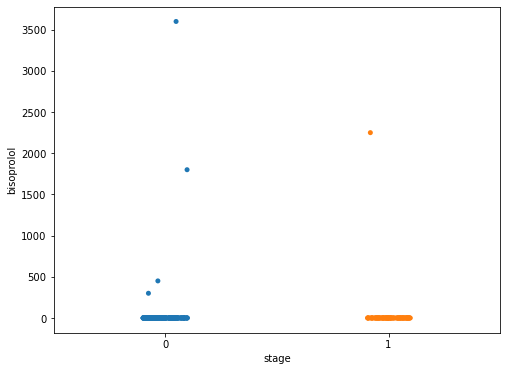

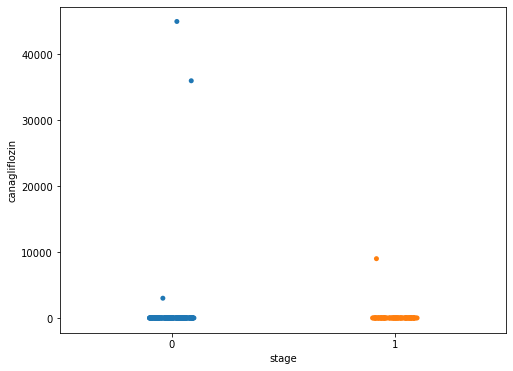

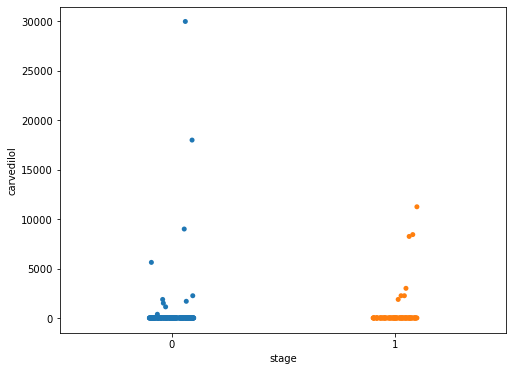

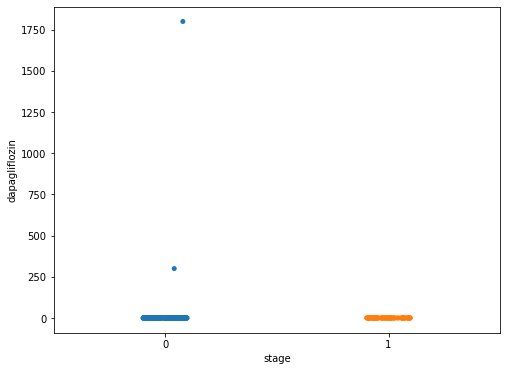

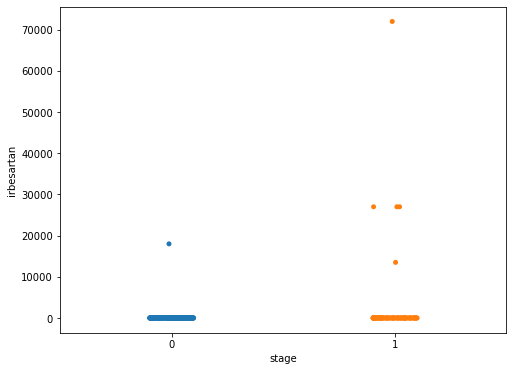

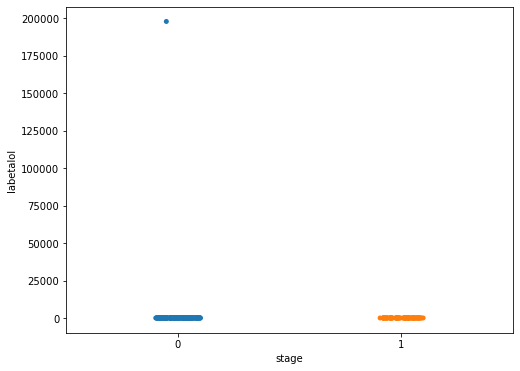

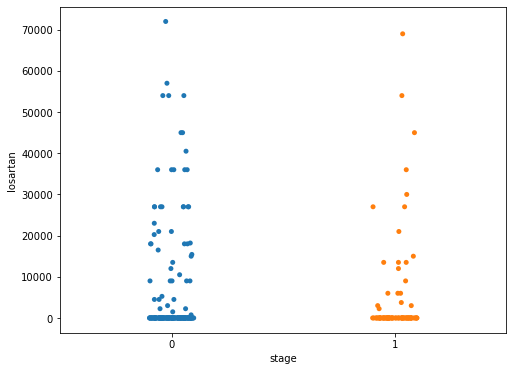

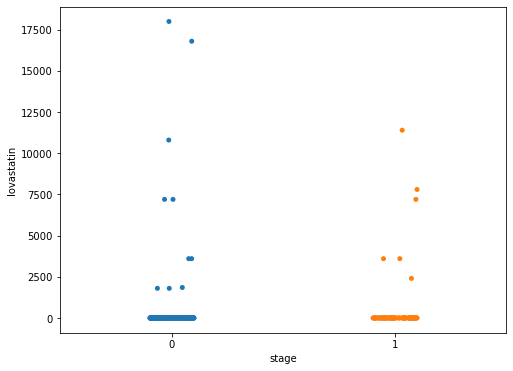

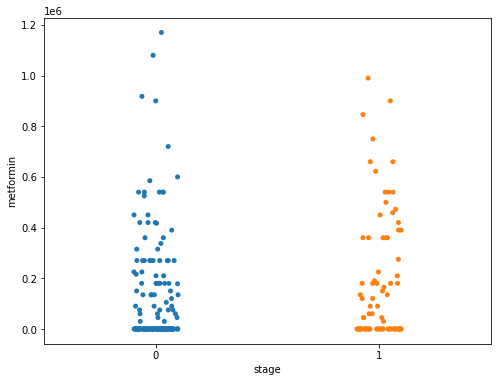

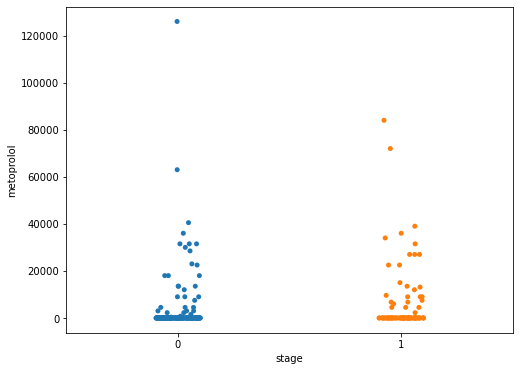

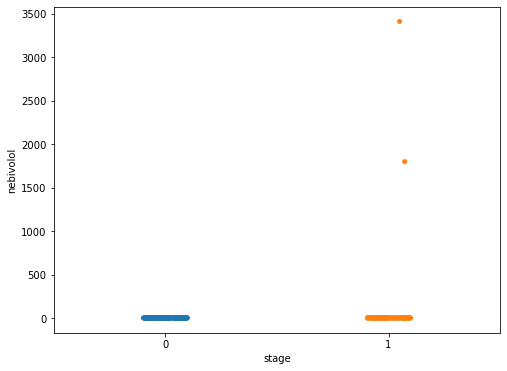

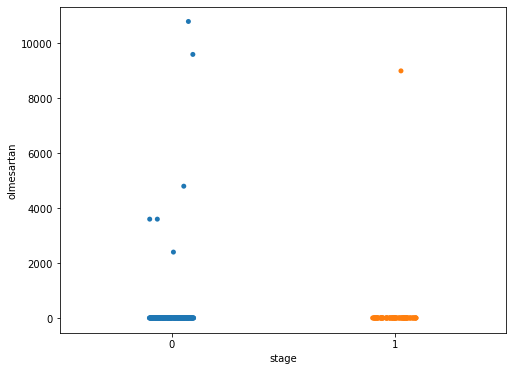

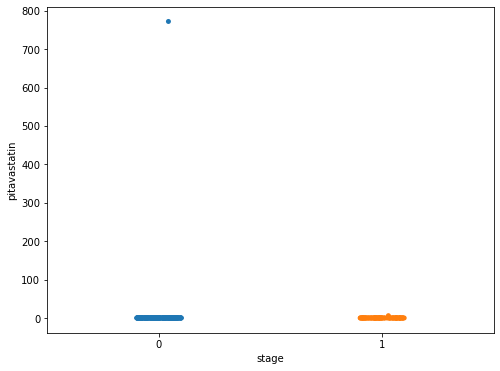

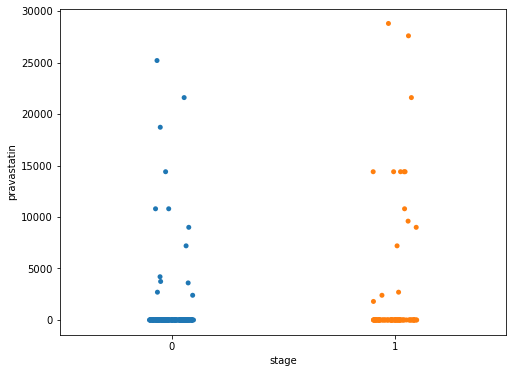

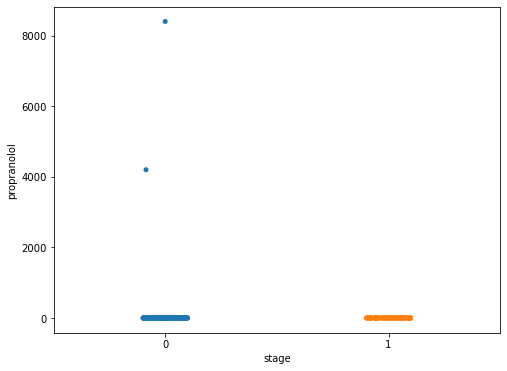

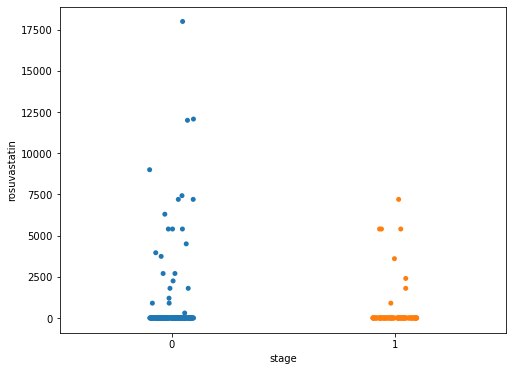

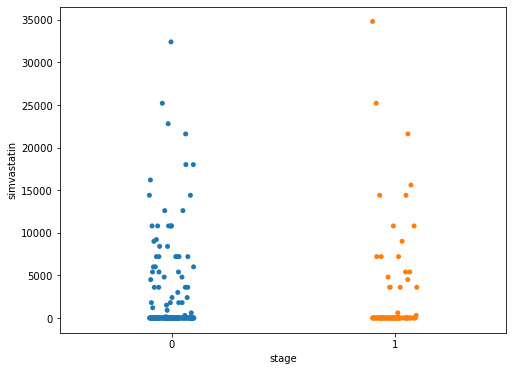

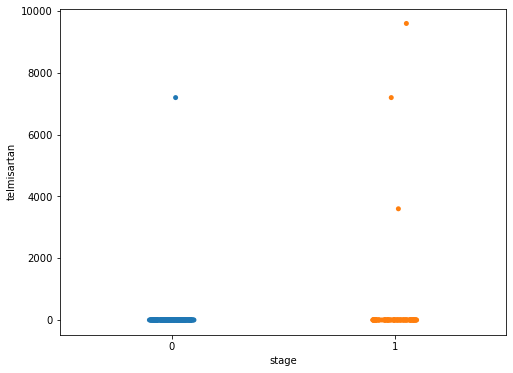

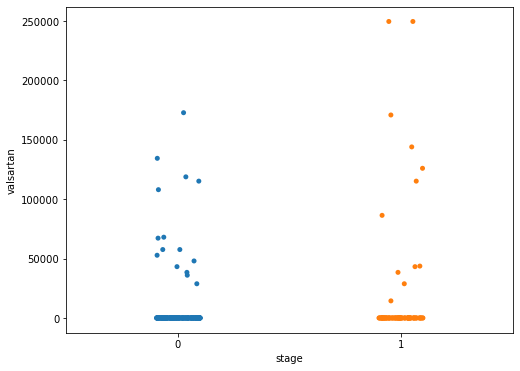

In [212]:
for col in meds_df.columns:
    plt.figure(figsize=(8, 6))
    sns.stripplot(data=overall_df, x='stage', y=col);    

In [213]:
# if there are less than 50 observations for a particular drug, drop feature

for col in meds_df.columns:
    try: 
        if overall_df[col].value_counts()[0] >= 250:
            overall_df.drop(col, axis=1, inplace=True)
    except:
        continue

In [214]:
# drop other columns that do not show significant variation

cols_to_drop = ['creatinine_std',
                'glucose_std',
                'haemoglobin_std',
                'low-density lipoprotein_mean',
                'low-density lipoprotein_std'
                ]

In [215]:
overall_df.drop(columns=cols_to_drop, inplace=True, axis=1)

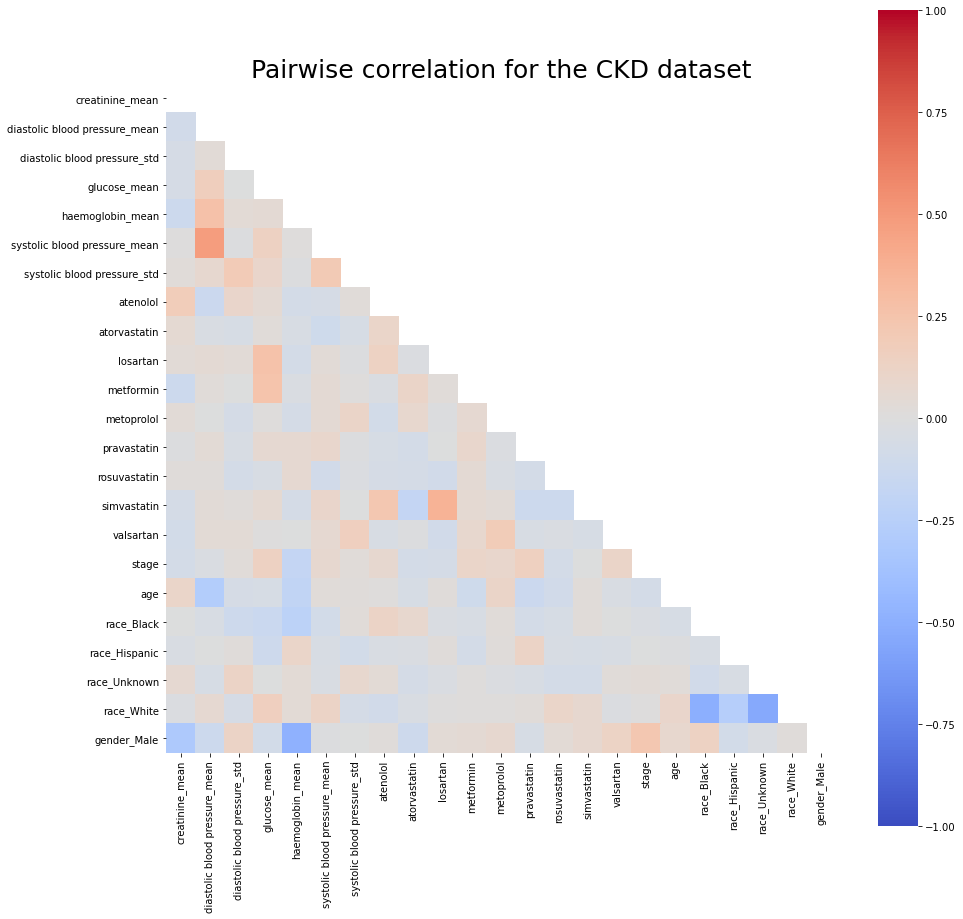

In [216]:
# generates a heatmap to visualize correlations between all numeric features

plt.figure(figsize=(15,15))

mask = np.triu(overall_df.corr()) 
sns.heatmap(overall_df.corr(), square=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Pairwise correlation for the CKD dataset', fontsize=25);

The predictor variables are generally not correlated with one another excepts for systolic and diastolic blood pressure, as well as the race predictors.

# Data Preprocessing

In [217]:
# define feature set

remaining_features = [col for col in overall_df._get_numeric_data() if col != 'stage']

In [218]:
# prepare training and test datasets

X = overall_df[remaining_features]
y = overall_df['stage']

In [219]:
# our baseline accuracy is 0.665 - imbalanced

y.value_counts(normalize=True)

0    0.665441
1    0.334559
Name: stage, dtype: float64

In [220]:
# split our training and testing data using test size of 0.25 and set random_state of 42 for reproducibility, stratify is on

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 

# Modelling

In [221]:
# set up pipelines for the various models

pipe_1 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=500))
])

pipe_2 = Pipeline([
    ('sampling', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

pipe_3 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_4 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('et', ExtraTreesClassifier(random_state=42))
])

pipe_5 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

pipe_6 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('gboost', GradientBoostingClassifier())
])

pipe_7 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('ada', AdaBoostClassifier())
])

pipe_8 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [222]:
# setting the parameters for each pipe

pipe_1_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'lr__C': [0.1, 0.3, 0.5, 1],
    'lr__solver': ['liblinear', 'lbfgs']
}

pipe_2_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'nb__alpha': [0.1, 0.3, 0.5, 1]
}

pipe_3_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'rf__n_estimators': [10, 20, 30],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [None, 1, 2, 3, 4],
    'rf__min_samples_split': [2, 3, 4, 5],
}

pipe_4_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'et__n_estimators': [10, 20, 30],
    'et__criterion': ['gini', 'entropy'],
    'et__max_depth': [None, 1, 2, 3, 4],
    'et__min_samples_split': [2, 3, 4, 5]
}

pipe_5_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'svm__C': [0.1, 0.3, 0.5, 1],
    'svm__kernel': ['rbf', 'linear', 'sigmoid'] 
}

pipe_6_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'gboost__learning_rate': [0.08, 0.1, 0.15],
    'gboost__n_estimators': [10, 20, 30], 
    'gboost__max_depth': [2, 3]
}

pipe_7_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'ada__learning_rate': [0.75, 1, 1.25],
    'ada__n_estimators': [10, 20, 30]
}

pipe_8_params = {
    'sampling__k_neighbors': [2, 3, 4],
    'knn__n_neighbors': [2, 3, 4, 5],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

In [223]:
# setting up the grid searches

gs_1 = GridSearchCV(estimator = pipe_1,
                    param_grid = pipe_1_params,
                    cv = 5,
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

gs_2 = GridSearchCV(estimator = pipe_2,
                    param_grid = pipe_2_params,
                    cv = 5,
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

gs_3 = GridSearchCV(estimator = pipe_3,
                    param_grid = pipe_3_params,
                    cv = 5,
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

gs_4 = GridSearchCV(estimator = pipe_4, 
                    param_grid = pipe_4_params,
                    cv = 5, 
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

gs_5 = GridSearchCV(estimator = pipe_5, 
                    param_grid = pipe_5_params,
                    cv = 5, 
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

gs_6 = GridSearchCV(estimator = pipe_6, 
                    param_grid = pipe_6_params,
                    cv = 5, 
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

gs_7 = GridSearchCV(estimator = pipe_7, 
                    param_grid = pipe_7_params,
                    cv = 5, 
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

gs_8 = GridSearchCV(estimator = pipe_8, 
                    param_grid = pipe_8_params,
                    cv = 5, 
                    scoring='recall',
                    verbose = 1,
                    n_jobs=-1)

In [224]:
grids = [gs_1, gs_2, gs_3, gs_4, gs_5, gs_6, gs_7, gs_8]

grid_dict = {0: 'Logistic Regression', 1: 'Multinomial Bayes', 
             2: 'Random Forest', 3: 'Extra Trees',
             4: 'Support Vector Machine', 5: 'Gradient Boosting',
             6: 'Ada Boosting', 7: 'K-Nearest Neighbors'
            }

In [225]:
for idx, gs in enumerate(grids):
    print(f'\nGridsearch on Estimator: {grid_dict[idx]}')
    
    # Fit grid search
    gs.fit(X_train, y_train)
    
    # showing best params
    print(f'Best params: {gs.best_params_}')
    
    # Best training score
    print(f'Best GridSearchCV recall: {round(gs.best_score_, 3)}')
    
    model = gs.best_estimator_
    
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
        
    # Scoring on validation data with best params
    print(f'Training AUC on best params: {round(roc_auc_score(y_train, y_train_pred), 3)}')    
    print(f'Validation AUC on best params: {round(roc_auc_score(y_test, y_test_pred), 3)}')
    print(f'Training recall on best params: {round(recall_score(y_train, model.predict(X_train)), 3)}')
    print(f'Validation recall on best params: {round(recall_score(y_test, model.predict(X_test)), 3)}')
    
    # Printing Confusion Matrix and Scoring reports
    print()
    print(f'Confusion Matrix for: {grid_dict[idx]}')
    print(confusion_matrix(y_test, gs.predict(X_test)))
    print()
    print(f'Scoring Report for: {grid_dict[idx]}')
    print(classification_report(y_test, gs.predict(X_test)))


Gridsearch on Estimator: Logistic Regression
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'lr__C': 0.3, 'lr__solver': 'liblinear', 'sampling__k_neighbors': 4}
Best GridSearchCV recall: 0.488
Training AUC on best params: 0.748
Validation AUC on best params: 0.6
Training recall on best params: 0.647
Validation recall on best params: 0.478

Confusion Matrix for: Logistic Regression
[[28 17]
 [12 11]]

Scoring Report for: Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.62      0.66        45
           1       0.39      0.48      0.43        23

    accuracy                           0.57        68
   macro avg       0.55      0.55      0.55        68
weighted avg       0.60      0.57      0.58        68


Gridsearch on Estimator: Multinomial Bayes
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'nb__alpha': 0.1, 'sampling__k_neighbors': 3}
Best GridSearchCV recall: 0.471
Tr

Extra trees model has the highest validation AUC and recall score.

The accuracy hovers around the baseline of 65%.

# Model Evaluation

In [226]:
# access the best model from the GridSearch

et = gs_4.best_estimator_

In [227]:
et.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('sampling', SMOTE(k_neighbors=2, random_state=42)),
                ('et',
                 ExtraTreesClassifier(criterion='entropy', max_depth=1,
                                      n_estimators=10, random_state=42))])

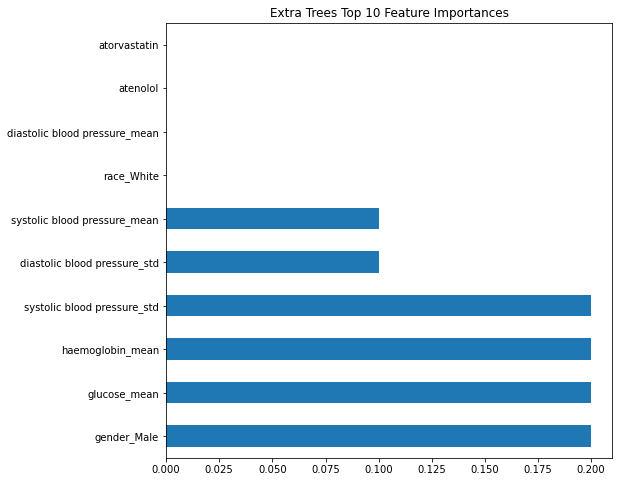

In [228]:
# access the feature importances from the gridsearch
feat_imp = et.named_steps['et'].feature_importances_

# tag with feature name and sort from most important to least
et_feat_imp = pd.Series(feat_imp, remaining_features).sort_values(ascending=False)

# getting the top 10 features
et_top10 = et_feat_imp[:10]

# plot top 10 features
plt.figure(figsize=(8,8))
et_top10.plot(kind='barh', title='Extra Trees Top 10 Feature Importances')
plt.show();

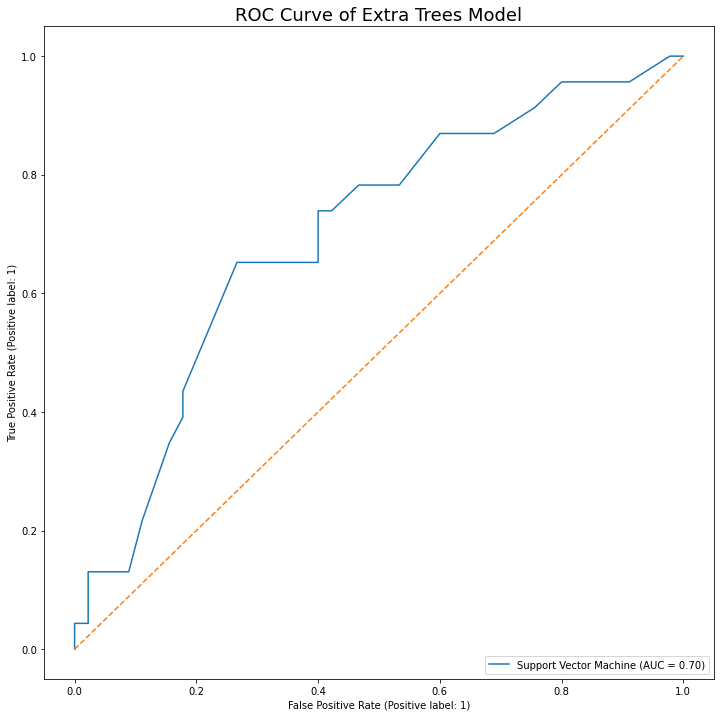

In [229]:
figure = plt.figure(figsize=(12,12))
ax = plt.gca()
plot_roc_curve(et, X_test, y_test, name=grid_dict[4], ax=ax)
ax.plot(np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        linestyle='--')
plt.title('ROC Curve of Extra Trees Model', fontsize=18);

In [230]:
predictions = et.predict(X_test)

In [231]:
misclass_df = pd.concat([X_test, y_test, pd.Series(predictions, name='predictions', index=y_test.index)], axis=1)

In [232]:
# dataframe of misclassified predictions

misclass_df.loc[misclass_df['stage'] != misclass_df['predictions'], :]

,creatinine_mean,diastolic blood pressure_mean,diastolic blood pressure_std,glucose_mean,haemoglobin_mean,systolic blood pressure_mean,systolic blood pressure_std,atenolol,atorvastatin,losartan,...,simvastatin,valsartan,age,race_Black,race_Hispanic,race_Unknown,race_White,gender_Male,stage,predictions
271,1.010000,74.970000,13.952049,5.980000,14.672000,114.737143,18.609681,0.0,1200.0,27000.0,...,0.0,0.0,84,0,0,0,0,1,0,1
163,1.165000,82.708571,5.334312,5.737143,13.883333,124.531429,14.802754,0.0,0.0,0.0,...,0.0,118800.0,73,0,0,0,1,1,0,1
80,1.331667,71.663333,8.821323,7.852500,13.140000,137.395000,12.716183,24000.0,0.0,0.0,...,7200.0,0.0,83,0,0,0,1,1,0,1
55,0.828000,79.586000,7.465382,7.050000,15.048571,121.952000,7.943873,0.0,0.0,0.0,...,0.0,0.0,67,0,0,0,1,1,1,0
200,1.118571,79.207143,6.390080,4.757500,13.666250,151.931429,14.517660,0.0,0.0,0.0,...,7200.0,172800.0,69,0,0,0,1,0,0,1
263,1.026000,73.032500,2.858384,7.915000,15.054286,138.875000,17.302274,0.0,0.0,0.0,...,1800.0,0.0,70,0,0,0,1,1,0,1
251,1.085000,77.645000,7.386149,5.792500,13.796667,161.151667,12.195306,0.0,0.0,45000.0,...,32400.0,0.0,68,0,0,0,1,1,0,1
77,1.145000,80.201667,7.242832,8.375000,13.242500,129.265000,6.179883,0.0,0.0,72000.0,...,25200.0,0.0,76,0,0,0,1,1,0,1
166,1.212000,74.254000,7.875299,5.810000,13.941250,127.962000,8.935825,0.0,18000.0,0.0,...,0.0,0.0,81,0,0,0,1,0,1,0
113,1.042000,91.848333,7.795266,6.848333,14.425455,146.886667,13.592659,0.0,21600.0,0.0,...,0.0,0.0,66,0,0,0,1,0,1,0


# Conclusion and Recommendations

A classification model was built to predict whether a patient was likely to progress to the next stage of CKD in the future, allowing for better targeted intervention and treatment to halt or control the disease.

The ET model scored a ROC-AUC of 0.699 and recall of 0.696 on the validation dataset. 

**Limitations**

- There is still a significant proportion of patients that will progress to the next stage of CKD that are unidentified by the model, as the recall is relatively low
- ROC-AUC is also relatively low, indicating that the model is not fully able to separate the positive and negative class distributions
- There is a degree of overfitting for each of the models which could not be completely eliminated

**Improvements to model**

- To better account for the variability in efficacy of drugs on the population, a mixed-effect model could be deployed
- Using more data points

# References

- Blood Sugar levels
    - https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html
    
- Blood pressure levels
    - https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained
    
- Chronic Kidney Disease
    - https://www.niddk.nih.gov/health-information/kidney-disease/chronic-kidney-disease-ckd/what-is-chronic-kidney-disease